In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
import statsmodels.api as sm
from sklearn.utils import resample
from scipy.stats import shapiro, mannwhitneyu

In [3]:
match_info_data = pd.read_csv("C:\\Users\\adity\\Downloads\\match_info_data.csv")
match_data = pd.read_csv("C:\\Users\\adity\\Downloads\\match_data.csv")

In [4]:
match_data.head()

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed,cricsheet_id
0,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.1,Gujarat Titans,Chennai Super Kings,WP Saha,Shubman Gill,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1370353
1,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.2,Gujarat Titans,Chennai Super Kings,WP Saha,Shubman Gill,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1370353
2,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.3,Gujarat Titans,Chennai Super Kings,WP Saha,Shubman Gill,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1370353
3,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.4,Gujarat Titans,Chennai Super Kings,Shubman Gill,WP Saha,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1370353
4,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.5,Gujarat Titans,Chennai Super Kings,WP Saha,Shubman Gill,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1370353


In [6]:
match_info_data['date'] = pd.to_datetime(match_info_data['date'], errors='coerce')
team_runs_per_match = match_data.groupby(['match_id', 'batting_team']) ['runs_off_bat'].sum().reset_index()
team_runs_per_match.rename(columns= {'runs_off_bat':'total_runs'}, inplace=True)
merged = pd.merge(team_runs_per_match, match_info_data[['id', 'date', 'venue', 'team1', 'team2']], left_on = 'match_id', right_on = 'id')
merged.drop(columns = ['id'], inplace = True)
merged['Period'] = merged['date'].dt.year.apply(lambda x: 'Pre' if x < 2018 else 'Post')
merged['run_rate'] = merged['total_runs'] / 20.0
merged['year'] = merged['date'].dt.year

In [7]:
merged.head()

,match_id,batting_team,total_runs,date,venue,team1,team2,Period,run_rate,year
0,335982,Kolkata Knight Riders,205,2008-04-18,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Pre,10.25,2008
1,335982,Royal Challengers Bangalore,63,2008-04-18,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Pre,3.15,2008
2,335983,Chennai Super Kings,234,2008-04-19,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Pre,11.70,2008
3,335983,Kings XI Punjab,196,2008-04-19,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Pre,9.80,2008
4,335984,Delhi Daredevils,122,2008-04-19,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Pre,6.10,2008


In [8]:
pre_scores = merged[merged['Period'] == 'Pre']['total_runs']
post_scores = merged[merged['Period'] == 'Post']['total_runs']
pre_normality = shapiro(pre_scores.sample(n=500, random_state=1) if len(pre_scores) > 500 else pre_scores)
post_normality = shapiro(post_scores.sample(n=500, random_state=1) if len(post_scores) > 500 else post_scores)
print("Shapiro-Wilk Test (Pre):", pre_normality)
print("Shapiro-Wilk Test (Post):", post_normality)

Shapiro-Wilk Test (Pre): ShapiroResult(statistic=np.float64(0.988417764270504), pvalue=np.float64(0.0005392374071367837))
Shapiro-Wilk Test (Post): ShapiroResult(statistic=np.float64(0.9845150224718922), pvalue=np.float64(3.6348381261299446e-05))


In [9]:
match_counts = match_info_data.groupby(match_info_data['date'].dt.year)['id'].nunique().reset_index()
match_counts.columns = ['season', 'match_count']
match_info_data['season'] = match_info_data['date'].dt.year
match_info_data['match_number'] = match_info_data.groupby('season')['date'].rank(method='first', ascending=True)
match_counts.set_index('season', inplace=True)
match_info_data['match_count'] = match_info_data['season'].map(match_counts['match_count'])
match_info_data['is_playoff'] = match_info_data['match_number'] > (match_info_data['match_count'] - 4)
merged = pd.merge(merged, match_info_data[['id', 'is_playoff']], left_on = 'match_id', right_on = 'id')
merged.drop(columns = ['id'], inplace = True)

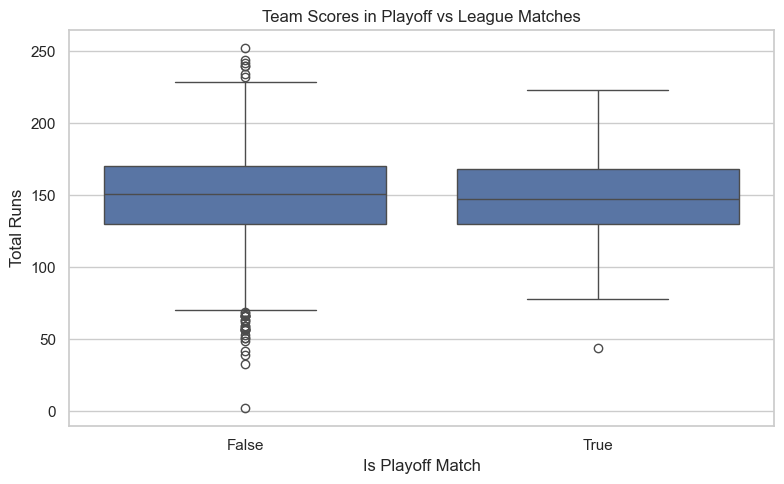

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize = (8,5))
sns.boxplot(data=merged, x='is_playoff', y = 'total_runs')
plt.title("Team Scores in Playoff vs League Matches")
plt.xlabel("Is Playoff Match")
plt.ylabel("Total Runs")
plt.tight_layout()
plt.show()

In [11]:
league_scores = merged[merged['is_playoff'] == False]['total_runs']
playoff_scores = merged[merged['is_playoff'] == True]['total_runs']
u_statistic, p_value = mannwhitneyu(league_scores, playoff_scores, alternative='two-sided')
print(f"Mann-Whitney U Statistic: {u_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The Difference in Scores between playoffs and league matches is statistically significant.")
else:
    print("No Statistically Significant Difference Between Playoffs and League Matches.")

Mann-Whitney U Statistic: 124606.0
P-value: 0.7668706992141119
No Statistically Significant Difference Between Playoffs and League Matches.


In [12]:
team_name = "Chennai Super Kings"
team_data = merged[merged['batting_team'] == team_name]
league_scores = team_data[team_data['is_playoff'] == False]['total_runs']
playoff_scores = team_data[team_data['is_playoff'] == True]['total_runs']
u_statistic, p_value = mannwhitneyu(league_scores, playoff_scores, alternative = 'two-sided')

print(f"Team: {team_name}")
print(f"Mann-Whitney U Statistics: {u_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("This Team shows a statistically significant scoring difference in playoffs vs league matches.")
else:
    print("No statistically significant scoring difference for this team.")

Team: Chennai Super Kings
Mann-Whitney U Statistics: 2261.0
P-value: 0.3326928611823903
No statistically significant scoring difference for this team.


In [13]:
teams = merged['batting_team'].unique()

for team in teams:
    team_data = merged[merged['batting_team'] == team]
    league_scores = team_data[team_data['is_playoff'] == False]['total_runs']
    playoff_scores = team_data[team_data['is_playoff'] == True]['total_runs']

    if len(playoff_scores) >=3 and len(league_scores) >= 3:
        u_stat, p_val = mannwhitneyu(league_scores, playoff_scores,alternative = 'two-sided')
        print(f"{team}: p = {p_val:.4f} {'✔️' if p_val <0.05 else '❌'}")

Kolkata Knight Riders: p = 0.8206 ❌
Royal Challengers Bangalore: p = 0.4337 ❌
Chennai Super Kings: p = 0.3327 ❌
Kings XI Punjab: p = 0.6591 ❌
Delhi Daredevils: p = 0.0892 ❌
Rajasthan Royals: p = 0.8971 ❌
Mumbai Indians: p = 0.4349 ❌
Deccan Chargers: p = 0.0997 ❌
Sunrisers Hyderabad: p = 0.7162 ❌
Delhi Capitals: p = 0.9859 ❌
Gujarat Titans: p = 0.4976 ❌


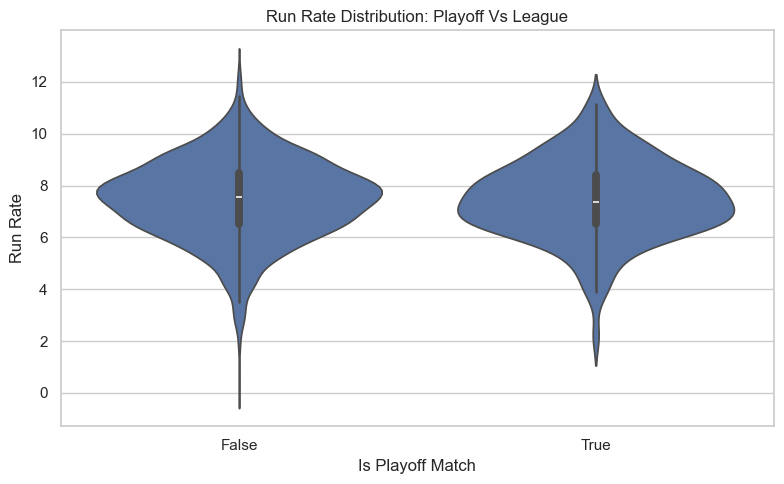

In [14]:
plt.figure(figsize=(8,5))
sns.violinplot(data = merged, x = 'is_playoff', y= 'run_rate')
plt.title("Run Rate Distribution: Playoff Vs League")
plt.xlabel("Is Playoff Match")
plt.ylabel("Run Rate")
plt.tight_layout()
plt.show()

In [15]:
league_run_rates = merged[merged['is_playoff'] == False]['run_rate']
playoff_run_rates = merged[merged['is_playoff'] == True]['run_rate']

u_statistic, p_value = mannwhitneyu(league_run_rates, playoff_run_rates, alternative = 'two-sided')
print(f"Mann-Whitney U Statistic: {u_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The Difference in Run Rates between playoffs and league matches is statistically significant.")
else:
    print("No Statistically Significant Difference in Run Rates between Playoffs and League Matches.")

Mann-Whitney U Statistic: 124606.0
P-value: 0.7668706992141119
No Statistically Significant Difference in Run Rates between Playoffs and League Matches.


In [16]:
results = []
teams = merged['batting_team'].unique()

for team in teams:
    team_data = merged[merged['batting_team'] == team]
    league_run_rates = team_data[team_data['is_playoff'] == False]['run_rate']
    playoff_run_rates = team_data[team_data['is_playoff'] == True]['run_rate']

    if len(league_run_rates) >= 3 and len(playoff_run_rates) >= 3:
        u_stat, p_val = mannwhitneyu(league_run_rates, playoff_run_rates, alternative = 'two-sided')
        results.append({
            'Team': team,
            'P-value': round(p_val, 4),
            'Significant': '✔️' if p_val < 0.05 else '❌'
        })
results_df = pd.DataFrame(results)
print(results_df)

                           Team  P-value Significant
0         Kolkata Knight Riders   0.8206           ❌
1   Royal Challengers Bangalore   0.4337           ❌
2           Chennai Super Kings   0.3327           ❌
3               Kings XI Punjab   0.6591           ❌
4              Delhi Daredevils   0.0892           ❌
5              Rajasthan Royals   0.8971           ❌
6                Mumbai Indians   0.4349           ❌
7               Deccan Chargers   0.0997           ❌
8           Sunrisers Hyderabad   0.7162           ❌
9                Delhi Capitals   0.9859           ❌
10               Gujarat Titans   0.4976           ❌


In [17]:
merged['home_team'] = merged['batting_team'] == merged['team1']
merged['away_team'] = merged['batting_team'] == merged['team2']

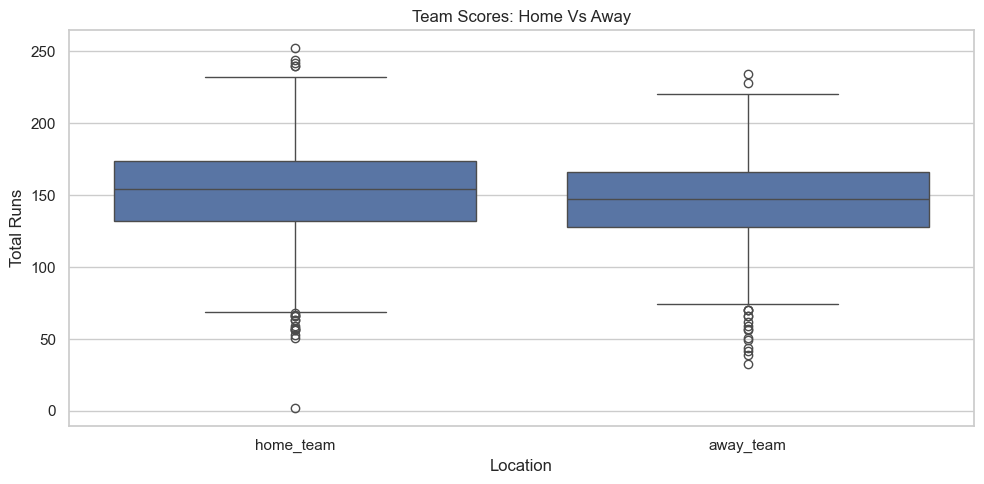

In [18]:
home_away_df = merged.melt(id_vars=['total_runs'], value_vars=['home_team', 'away_team'],
                          var_name='location', value_name='is_true')

home_away_df = home_away_df[home_away_df['is_true']]

plt.figure(figsize=(10,5))
sns.boxplot(data = home_away_df, x= 'location', y = 'total_runs')
plt.title("Team Scores: Home Vs Away")
plt.xlabel("Location")
plt.ylabel("Total Runs")
plt.tight_layout()
plt.show()

In [19]:
home_scores = merged[merged['home_team'] == True]['total_runs']
away_scores = merged[merged['home_team'] == False]['total_runs']

u_statistic, p_value = mannwhitneyu(home_scores, away_scores, alternative='two-sided')

print(f"Mann-Whitney U Statistic: {u_statistic}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("The Difference in scores between home and away matches is statistically significant.")
else:
    print("No Statistically Significant Difference in scores between home and away matches.")

Mann-Whitney U Statistic: 581106.0
P-Value: 1.2376099361250965e-05
The Difference in scores between home and away matches is statistically significant.


In [20]:
print("Number of Missing Values")
print(merged.isnull().sum())

print("Check if any missing value exist")
print(merged.isnull().any())

print("Percent of Missing Values Per Column")
missing_percent = merged.isnull().mean() * 100
print(missing_percent)

print("Show just the rows that have any missing data")
missing_rows = merged[merged.isnull().any(axis=1)]
print(missing_rows.head())

Number of Missing Values
match_id        0
batting_team    0
total_runs      0
date            0
venue           0
team1           0
team2           0
Period          0
run_rate        0
year            0
is_playoff      0
home_team       0
away_team       0
dtype: int64
Check if any missing value exist
match_id        False
batting_team    False
total_runs      False
date            False
venue           False
team1           False
team2           False
Period          False
run_rate        False
year            False
is_playoff      False
home_team       False
away_team       False
dtype: bool
Percent of Missing Values Per Column
match_id        0.0
batting_team    0.0
total_runs      0.0
date            0.0
venue           0.0
team1           0.0
team2           0.0
Period          0.0
run_rate        0.0
year            0.0
is_playoff      0.0
home_team       0.0
away_team       0.0
dtype: float64
Show just the rows that have any missing data
Empty DataFrame
Columns: [match_id, bat

In [21]:
merged.dropna(subset = ['date', 'total_runs', 'run_rate'], inplace = True)

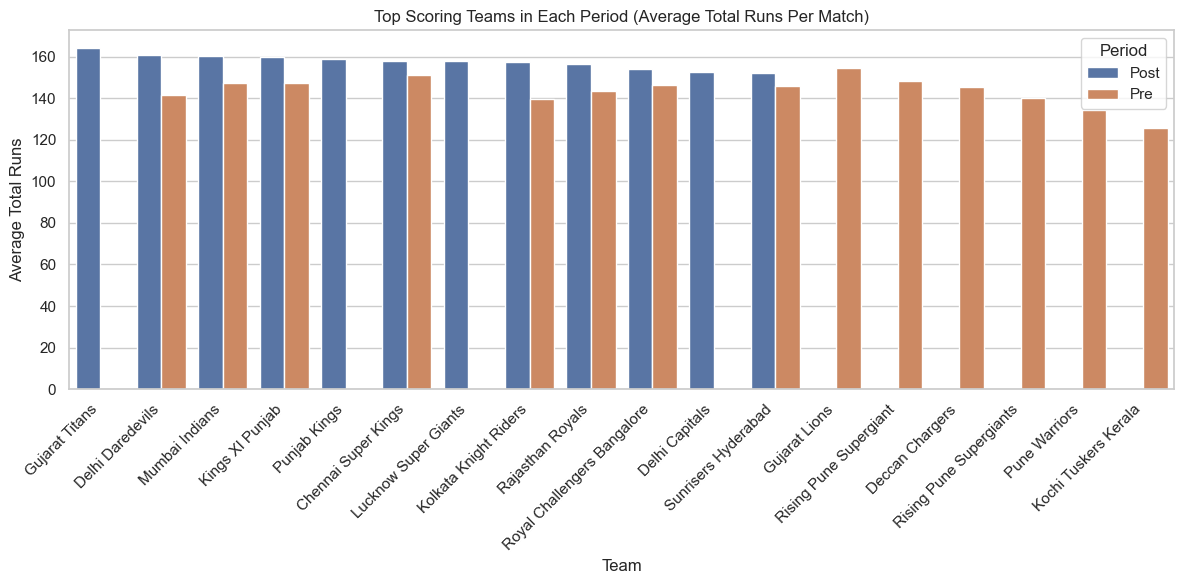

In [22]:
top_scoring_teams = (
    merged.groupby(['batting_team', 'Period'])['total_runs']
    .mean()
    .reset_index()
    .sort_values(by=['Period', 'total_runs'], ascending=[True, False])
)

plt.figure(figsize=(12, 6))
sns.barplot(data = top_scoring_teams, x='batting_team', y='total_runs', hue='Period')

plt.title("Top Scoring Teams in Each Period (Average Total Runs Per Match)")
plt.ylabel("Average Total Runs")
plt.xlabel("Team")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

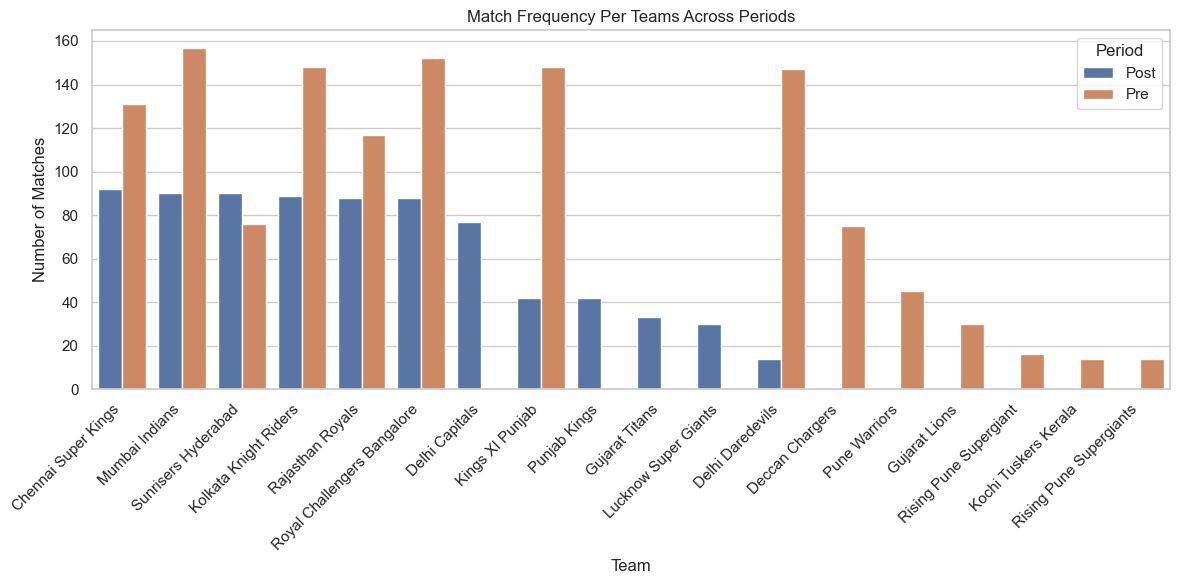

In [23]:
match_freq = (
    merged.groupby(['batting_team', 'Period'])['match_id']
    .nunique()
    .reset_index()
    .rename(columns={'match_id': 'match_count'})
)

match_freq = match_freq.sort_values(by=['Period', 'match_count'], ascending=[True, False])

plt.figure(figsize=(12, 6))
sns.barplot(data = match_freq, x='batting_team', y='match_count', hue='Period')

plt.title("Match Frequency Per Teams Across Periods")
plt.ylabel("Number of Matches")
plt.xlabel("Team")
plt.xticks(rotation=45, ha= 'right')
plt.tight_layout()
plt.show()

In [24]:
min_matches = 10

match_counts = (
    merged.groupby(['batting_team', 'Period'])['match_id']
    .nunique()
    .reset_index()
    .rename(columns={'match_id': 'match_count'})
)
match_counts_pivot = match_counts.pivot(index='batting_team', columns = 'Period', values='match_count').fillna(0)
qualified_teams = match_counts_pivot[
    (match_counts_pivot.get('Pre', 0) >= min_matches) &
    (match_counts_pivot.get('Post', 0) >= min_matches)
].index.tolist()

filtered_merged = merged[merged['batting_team'].isin(qualified_teams)]

print("Qualified Teams:", qualified_teams)
print("Filtered Dataset Size:", filtered_merged.shape)

Qualified Teams: ['Chennai Super Kings', 'Delhi Daredevils', 'Kings XI Punjab', 'Kolkata Knight Riders', 'Mumbai Indians', 'Rajasthan Royals', 'Royal Challengers Bangalore', 'Sunrisers Hyderabad']
Filtered Dataset Size: (1669, 13)


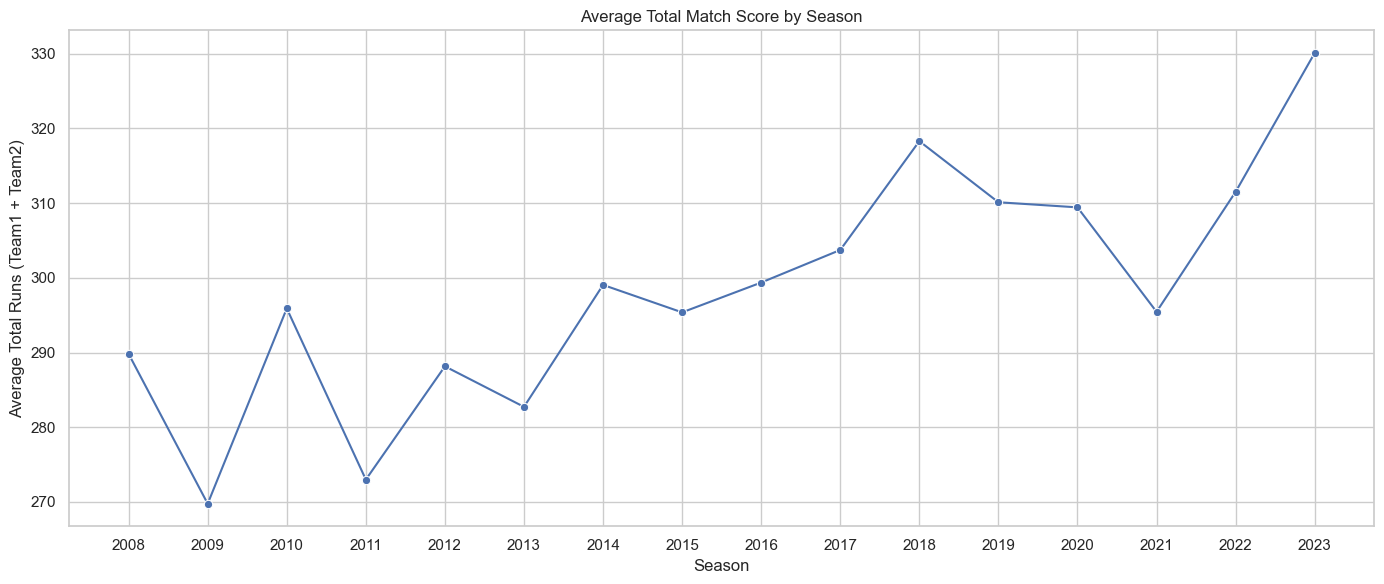

In [25]:
match_totals = (
    merged.groupby(['match_id', 'batting_team'])['total_runs']
    .sum()
    .reset_index()
)

match_scores = (
    match_totals.groupby('match_id')['total_runs']
    .sum()
    .reset_index()
    .rename(columns = {'total_runs' : 'total_match_score'})
)
match_info = match_info_data[['id', 'date']].copy()
match_info['date'] = pd.to_datetime(match_info['date'], errors='coerce')
match_info.rename(columns={'id': 'match_id'}, inplace = True)

match_scores = pd.merge(match_scores, match_info, on='match_id')

match_scores['year'] = match_scores['date'].dt.year

seasonal_scores = (
    match_scores.groupby('year')['total_match_score']
    .mean()
    .reset_index()
    .rename(columns = {'total_match_score': 'avg_total_match_score'})
)

plt.figure(figsize=(14, 6))
sns.lineplot(data = seasonal_scores, x='year', y='avg_total_match_score', marker = 'o')
plt.title("Average Total Match Score by Season")
plt.xlabel("Season")
plt.ylabel("Average Total Runs (Team1 + Team2)")
plt.xticks(seasonal_scores['year'])
plt.grid(True)
plt.tight_layout()
plt.show()

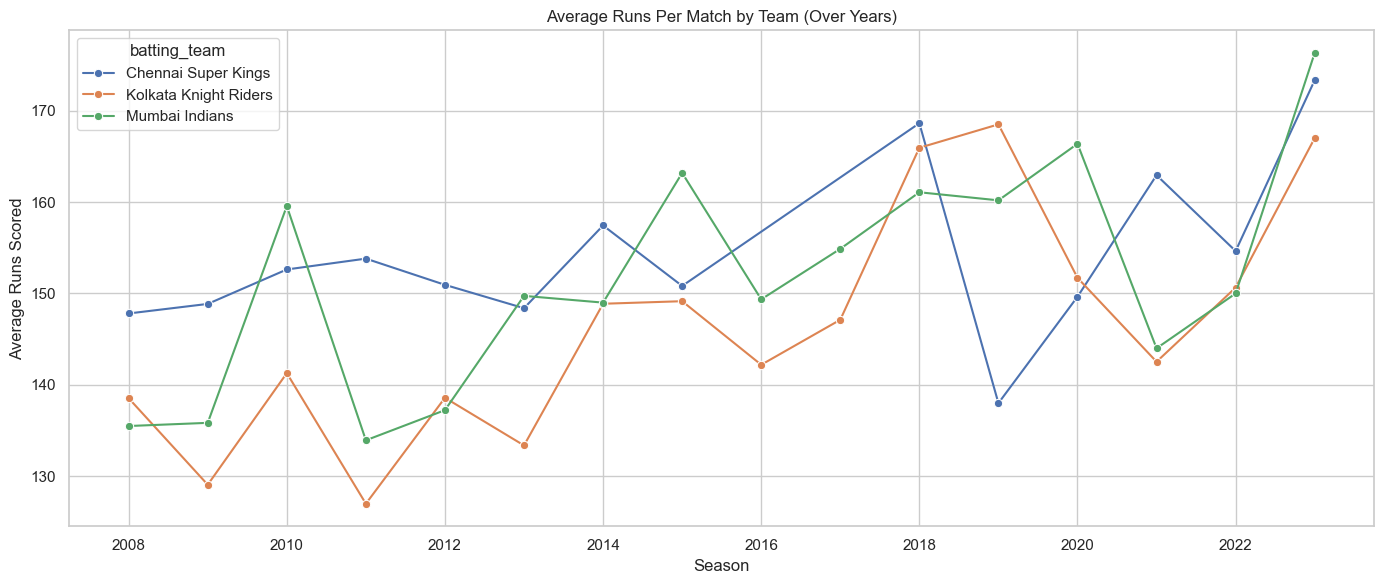

In [26]:
team_scores_by_year = (
    merged.groupby(['batting_team', 'year'])['total_runs']
    .mean()
    .reset_index()
    .rename(columns={'total_runs': 'avg_score'})
)

plt.figure(figsize = (14, 6))
top_teams = ['Chennai Super Kings', 'Mumbai Indians', 'Royal Challengers Banglore', 'Kolkata Knight Riders']
sns.lineplot(data = team_scores_by_year[team_scores_by_year['batting_team'].isin(top_teams)],
            x='year', y='avg_score', hue='batting_team', marker = 'o')
plt.title("Average Runs Per Match by Team (Over Years)")
plt.xlabel("Season")
plt.ylabel("Average Runs Scored")
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
from scipy.stats import skew, kurtosis

print("Skewness of total runs:", skew(merged['total_runs']))
print("Kurtosis of total runs:", kurtosis(merged['total_runs']))

print("Skewness of run rate:", skew(merged['run_rate']))
print("Kurtosis of run rate:", kurtosis(merged['run_rate']))

merged['home_team_int'] = merged['home_team'].astype(int)
merged['away_team_int'] = merged['away_team'].astype(int)

correlation_matrix = merged[['total_runs', 'run_rate', 'year', 'home_team_int', 'away_team_int']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

Skewness of total runs: -0.316126444960667
Kurtosis of total runs: 0.597009096235078
Skewness of run rate: -0.31612644496066417
Kurtosis of run rate: 0.5970090962350754

Correlation Matrix:
               total_runs  run_rate      year  home_team_int  away_team_int
total_runs       1.000000  1.000000  0.208131       0.096941      -0.096941
run_rate         1.000000  1.000000  0.208131       0.096941      -0.096941
year             0.208131  0.208131  1.000000       0.000238      -0.000238
home_team_int    0.096941  0.096941  0.000238       1.000000      -1.000000
away_team_int   -0.096941 -0.096941 -0.000238      -1.000000       1.000000


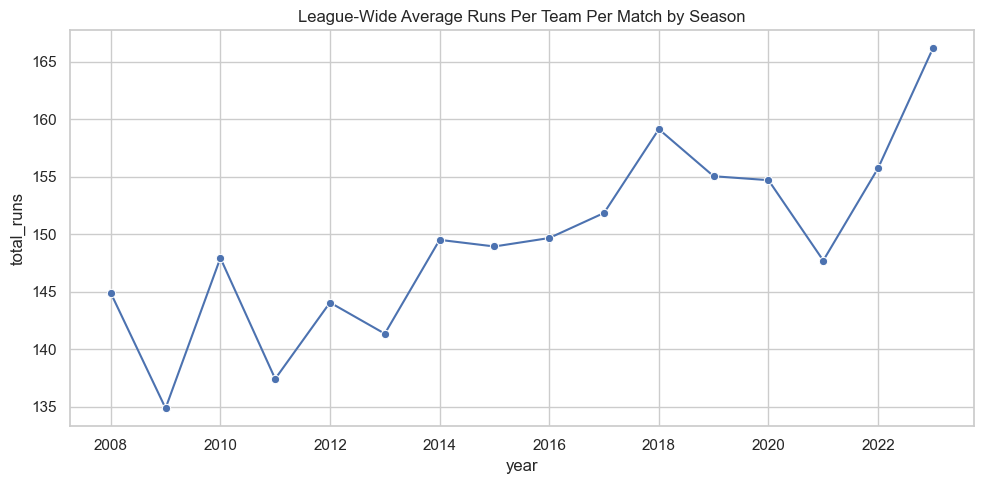

In [28]:
seasonal_avg = merged.groupby('year')['total_runs'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(data = seasonal_avg, x='year', y='total_runs', marker='o')
plt.title("League-Wide Average Runs Per Team Per Match by Season")
plt.grid(True)
plt.tight_layout()
plt.show()

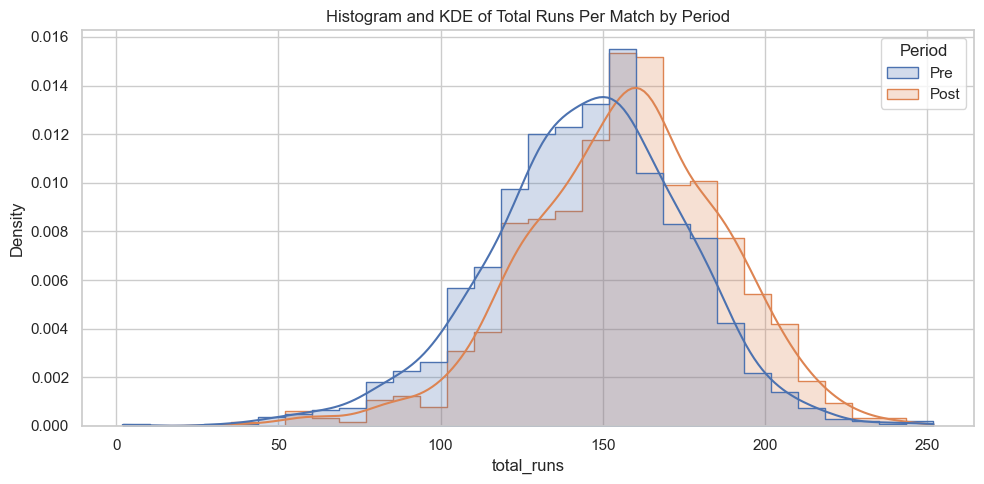

In [31]:
plt.figure(figsize=(10,5))
sns.histplot(data=merged, x='total_runs', hue = 'Period', element='step', stat='density', common_norm=False, kde=True, bins=30)
plt.title("Histogram and KDE of Total Runs Per Match by Period")
plt.tight_layout()
plt.show()

In [32]:
u_stat, p_val = mannwhitneyu(pre_scores, post_scores, alternative='two-sided')
print(f"Mann-Whitney U Test: U-statistic: {u_stat}, P_value: {p_val}")

Mann-Whitney U Test: U-statistic: 381621.5, P_value: 1.454889995517028e-17


In [33]:
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny-1)*np.var(y, ddof=1))/dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

effect_size = cohen_d(post_scores, pre_scores)
print("Cohen's D Effect Size:", effect_size)

Cohen's D Effect Size: 0.39017396117405473


In [41]:
def bootstrap_diff_means(x, y, n_bootstrap=1000):
    diffs = [np.mean(resample(y)) - np.mean(resample(x)) for _ in range(n_bootstrap)]
    return np.percentile(diffs, [2.5, 97.5]), np.mean(diffs)

ci_bounds, mean_diff = bootstrap_diff_means(pre_scores, post_scores)
print("95% Confidence Interval:", ci_bounds, "\nMean Difference:", mean_diff)

95% Confidence Interval: [ 9.26046876 14.66259868] 
Mean Difference: 11.937019908559817


In [43]:
seasonal_data = merged.groupby('year')['total_runs'].mean().reset_index()
X = sm.add_constant(seasonal_data['year'])
y = seasonal_data['total_runs']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             total_runs   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     25.68
Date:                Tue, 15 Jul 2025   Prob (F-statistic):           0.000172
Time:                        11:09:55   Log-Likelihood:                -47.087
No. Observations:                  16   AIC:                             98.17
Df Residuals:                      14   BIC:                             99.72
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2569.0983    536.414     -4.789      0.0

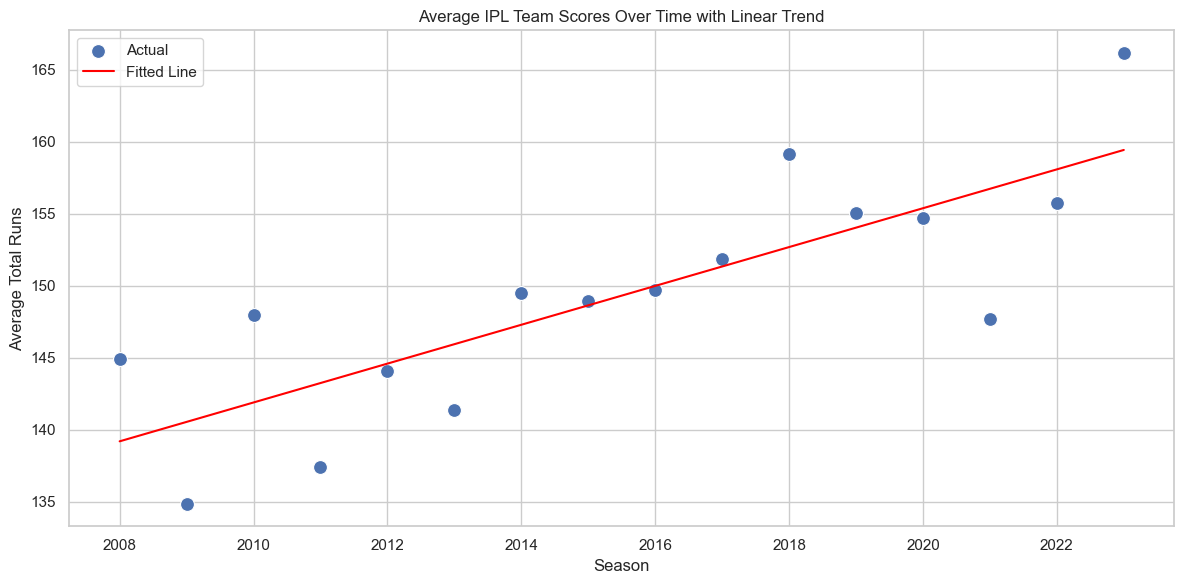

In [44]:
seasonal_data['predicted'] = model.predict(X)

plt.figure(figsize=(12,6))
sns.scatterplot(data = seasonal_data, x='year', y='total_runs', label='Actual', s=100)
sns.lineplot(data=seasonal_data, x='year', y='predicted', label='Fitted Line', color='red')

plt.title("Average IPL Team Scores Over Time with Linear Trend")
plt.xlabel("Season")
plt.ylabel("Average Total Runs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()